### Imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
root = "/Users/phdenzel/gleam"
sys.path.append(root)
import gleam
from gleam.utils.lensing import LensModel
from gleam.utils.plotting import kappa_map_plot, plot_scalebar


### Load data

In [2]:
#        ACS          ACS(WFC3)        ACS(WFC3)      WFC3(UNK)
#        ACS(WFC3)    SBC              WFC3           ACS(GAIA)
objs = ['B1608+656', 'DESJ0408-5354', 'HE0435-1223', 'PG1115+080',
        'RXJ0911+0551', 'RXJ1131-1231', 'SDSSJ1004+4112', 'WFIJ2033-4723']
objidx = 0
lens = objs[objidx]
print(lens)


B1608+656


In [3]:
statedir = 'states/'
statefiles = ['11doubles_dg45.state',
              '11doubles_dg60.state', '11doubles_CMB_dg60.state', '11doubles_SNeIa_dg60.state',
              '7quads_dg45.state', '7quads_CMB_dg45.state', '7quads_SNeIa_dg45.state',
              '7quads_dg60.state', '7quads_CMB_dg60.state', '7quads_SNeIa_dg60.state', 
              'all_dg60.state', 'all_SNeIa_dg60.state']
statefile = statefiles[7]
print(statefile)


7quads_dg60.state


In [4]:
lm = LensModel(statedir+statefile)
lm.obj_idx = objidx
print(lm.__v__)


filename            	7quads_dg60.state
filepath            	states/7quads_dg60.state
N                   	1000
pixrad              	8
maprad              	1.84670387036
pixel_size          	0.0434518557732
kappa               	None
minima              	[[-0.8215179170393514   1.2798384391770945 ]
 [ 1.0982397417262912   0.42373029405187596]]
saddle_points       	[[ 0.6745094476744152   1.2020104259838928 ]
 [-0.22483648255813793 -0.6399192195885473 ]]
maxima              	[]
zl                  	0.63
zs                  	1.39
N_obj               	8
N_src               	1
obj_idx             	0
src_idx             	0


In [5]:
%%script false
# Prepare PCA data (refined grid)
dims = (2*lm.pixrad+1)*lm.env.objects[0].basis.subdivision
ea = lm.ensemble_average.reshape(dims**2)
darr = lm.data
darr = darr.reshape((darr.shape[0], dims**2))
darr = darr - ea

print darr.shape, dims


In [6]:
# Prepare PCA data (coarse grid)
dims = (2*lm.pixrad+1)
ea = lm.kappa_grid(-1, refined=False).reshape(dims**2)
darr = lm.data_toplevel
darr = darr.reshape((darr.shape[0], dims**2))
darr = darr - ea

print darr.shape, np.mean(darr)


(1000, 289) -7.2268054e-09


### Inspect statistics

In [7]:
covm = np.cov(darr)  # np.cov(darr)
print covm.shape

lambdas, eigvs = np.linalg.eig(covm)
print lambdas.max(), lambdas.min()
print lambdas[0:3]


(1000, 1000)
(1.490780502535047+0j) (-1.7102607616846524e-16+0j)
[1.490780502535047 +0.j 1.1188892957562722+0.j 0.8616809211257344+0.j]


In [8]:
ilam = np.argsort(lambdas)[::-1]


### Run PCA

In [9]:
# Standardize data
scaler = StandardScaler()
scaler.fit(darr)
std_arr = scaler.transform(darr)


In [10]:
pca = PCA(n_components=100)
pca.fit(std_arr)
pca_arr = pca.transform(std_arr)
std_arr.shape, pca_arr.shape


((1000, 289), (1000, 100))

In [11]:
pcacs = pca.components_
pcacs = pcacs.reshape((pcacs.shape[0], dims, dims))
print pcacs.shape


(100, 17, 17)


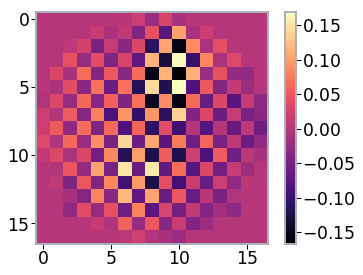

In [12]:
plt.imshow(pcacs[0], cmap='magma')
plt.colorbar()
plt.show()


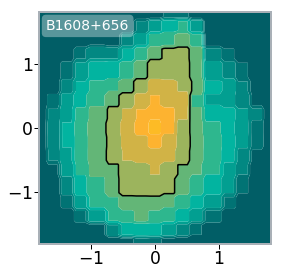

In [13]:
kappa_map_plot(lm, mdl_index=-1, obj_index=objidx, extent=lm.extent,
               contours=True, levels=7, delta=0.1, label=lm.obj_name)
plt.show()


In [14]:
npca = 0
warr = darr.reshape((1000, 17, 17)) * pcacs[npca, :]
dprods = np.sum(warr, axis=(1, 2))
print dprods.shape
print dprods.max(), dprods.min()
sorted_dprods = dprods.argsort()[::-1]
print sorted_dprods[0:10], sorted_dprods[-10:]


(1000,)
2.1415462 -1.9128203
[888 264 291 712 652 366 296 270 645 452] [ 88 384 392 219 608 282 163 794 185 869]


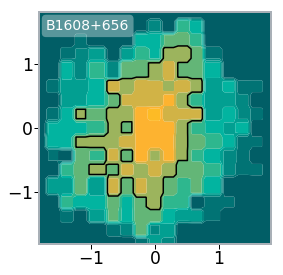

In [15]:
kappa_map_plot(lm, mdl_index=sorted_dprods[160], obj_index=objidx, extent=lm.extent,
               contours=True, levels=7, delta=0.1, label=lm.obj_name)
# plt.savefig("results/{}_kappa_pca{}_{}.pdf".format(lens, npca+1, 0.16), transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


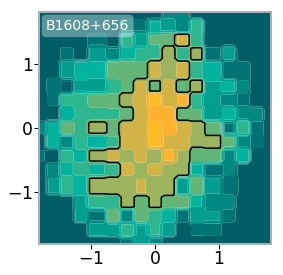

In [16]:
kappa_map_plot(lm, mdl_index=sorted_dprods[840], obj_index=objidx, extent=lm.extent,
               contours=True, levels=7, delta=0.1, label=lm.obj_name)
# plt.savefig("results/{}_kappa_pca{}_{}.pdf".format(lens, npca+1, 0.84), transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


In [17]:
%%script false
for npca in [0, 1, 2, 3, 4, 9, 24, 49, 99]:
    warr = darr.reshape((1000, 17, 17)) * pcacs[npca, :]
    dprods = np.sum(warr, axis=(1, 2))
    sorted_dprods = dprods.argsort()[::-1]
    kappa_map_plot(lm, mdl_index=sorted_dprods[160], obj_index=objidx, extent=lm.extent,
                   contours=True, levels=7, delta=0.1, label=lm.obj_name)
    plot_scalebar(R=lm.maprad, length=max(int(lm.maprad/2), 1))
    plt.axis('off')
    plt.gcf().axes[0].get_xaxis().set_visible(False)
    plt.gcf().axes[0].get_yaxis().set_visible(False)
    plt.savefig("results/{}_kappa_pca{}_{}.pdf".format(lens, npca+1, 0.16), transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()
    kappa_map_plot(lm, mdl_index=sorted_dprods[840], obj_index=objidx, extent=lm.extent,
                   contours=True, levels=7, delta=0.1, label=lm.obj_name)
    plot_scalebar(R=lm.maprad, length=max(int(lm.maprad/2), 1))
    plt.axis('off')
    plt.gcf().axes[0].get_xaxis().set_visible(False)
    plt.gcf().axes[0].get_yaxis().set_visible(False)
    plt.savefig("results/{}_kappa_pca{}_{}.pdf".format(lens, npca+1, 0.84), transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()
